# makemore part 5: Building a WaveNet

## What is makemore?

Makemore "makes more" of things that you give it. Example uses `names.txt` and makemore learns to make names

Under the hood, makemore is a character-level language model: it treats each line as sequences of individual characters. Model sequence of characters and try to predict next characters in a sequence.

This class will look at 
1. Bigram (one character simply predicts a next one with a lookup table of counts)
2. ~~Bag of Words~~
   1. The table explodes! We'll skip
3. **Multilayer Perceptron**
4. Recurrent Neural Network
5. GRU
6. Transformers

Will build a transformer equivalent to GPT-2, at the level of characters

## Agenda
Characters
Words
Images

## WaveNet

In this lecture, we will manually work through WaveNet because we have been compressing down to a single hidden layer with only a few characters. We will end up making WaveNet which is a much more complicated architecture.


---

## External Resources

### Lesson

[Makemore part 5](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)


___

## Import necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

---

In [2]:
# read in all the words
names_data = '../../data/raw/names.txt'

words = open(names_data, 'r').read().splitlines()

print(len(words))
print(max(len(w) for w in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i  in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words 
import random
random.seed(42)
random.shuffle(words)

In [15]:
# build the dataset but via a function instead
block_size = 8 # context length: how many characters do we take to predict the next one?
    
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [16]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [7]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)                 # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)    # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))  # normalizing to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42); #seed rng for reproducibility

In [17]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# this is before PyTorchifiying the code
# C = torch.randn((vocab_size, n_embd))

layers = [
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

model = Sequential(layers)

# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # make last layer less confident

# this is before PyTorchifiying the code
# parameters = [C] + [p for layer in layers for p in layer.parameters()]

parameters = model.parameters()

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22097


In [22]:
# let's look at a batch of just 4 examples
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 13,  1,  9, 19],
        [ 0,  0,  0,  0,  7,  1, 18, 18],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [23]:
# output of Embedding layer
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [24]:
# output of Flatten layer
model.layers[1].out.shape

torch.Size([4, 80])

In [25]:
# output of Linear layer
model.layers[2].out.shape

torch.Size([4, 200])

In [27]:
e = torch.randn(4, 8, 10)

# goal: we want this to be (4,4,20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:,::2,:], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [ ]:
e.view(4, 4, 20)

In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    # this is before PyTorchifiying the code
    # emb = C[Xb] # embed the characters into vectors
    # x = emb.view(emb.shape[0], -1) # concatenate the vectors
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    logits = model(Xb)
    # loss = F.cross_entropy(x, Yb)
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0 /  200000: 3.2966
  10000 /  200000: 2.2322
  20000 /  200000: 2.4111
  30000 /  200000: 2.1004
  40000 /  200000: 2.3157
  50000 /  200000: 2.2104
  60000 /  200000: 1.9653
  70000 /  200000: 1.9767
  80000 /  200000: 2.6738
  90000 /  200000: 2.0837
 100000 /  200000: 2.2730
 110000 /  200000: 1.7087
 120000 /  200000: 2.3243
 130000 /  200000: 2.2512
 140000 /  200000: 2.0113
 150000 /  200000: 1.8195
 160000 /  200000: 1.7985
 170000 /  200000: 2.2206
 180000 /  200000: 2.0566
 190000 /  200000: 2.1030


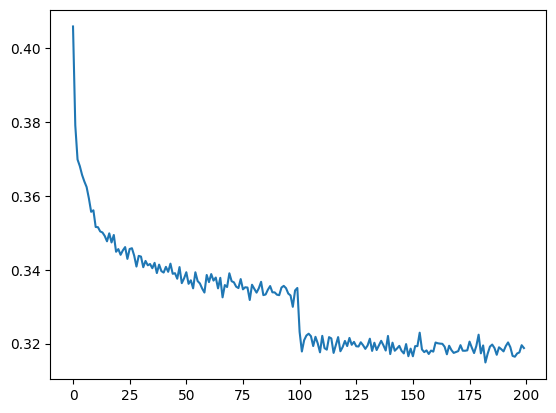

In [18]:
# plt.plot(lossi);
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1));

In [19]:
# put layers into eval mode (needed for BatchNorm especially)
for layer in model.layers:
    layer.training = False

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    # this is before PyTorchifiying the code
    # emb = C[x] # (N, block_size, n_embd)
    # x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    # for layer in layers:
    #     x = layer(x)
    
    logits = model(x)
    # loss = F.cross_entropy(x, y)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2949328422546387
val 3.2950856685638428


In [21]:
# sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        # forward pass the neural net
        # this is before PyTorch-ifying the code
        # emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        # x = emb.view(emb.shape[0], -1)
        # for layer in layers:
        #     x = layer(x)
        # logits = x

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) #decode and print the generated word

gygwj.
ugrzphalyhnqlplghxnaagadtdfugdqqisuubtaoqzdzvxjvkxepfrvyuibmaugqrcoxxdzbplyfarizmvdofxpqatxljgvybwzj.
kpjkthliyebtignjxlefnhzgbejpxghhifblwp.
xfmposcdfablritdrnghn.
qbhyzcavtnsskfubnmnlyp.
dxfqdcftwt.
wrt.
vdkdzvfyjfbusaxpodvfnmycyqxwruubgnminrlbdrjsjg.
gcedj.
zovcvwc.
pnznbymkxoqhpv.
jevoogkcwfoqovembruacbofpehkrptrbsilemildchilaaexuwukyvycxxubhgigmsgamrwmaibhpzwzyowsojjvlblxtaytnua.
aqvxgltxudlqzvobcs.
gibrrxtkyfzdseldrkyrw.
kclcxdmmnrpdjnigubuwgnlvmbwwxctaphbytkiexigw.
iirvsecdfkkjuwebtjsmt.
ekmpctqn.
bohnqgprmufhexxyqvvxiavvzyzpcnkabxymgclmqqavljhmvgamltqwkuleqrfhjnxexdlnxlozrcuggkxtwuvqpkxregaoaueskjcarqxewezgwxzvnlcqffepb.
nugomxrwirkecyulqvjgjmzsku.
tptjacmcrktkoejwa.


In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer 
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True) # note: Bessel's corection (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# non-linearity
h = torch.tanh(hpreact) # hidden layer

# linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) isntead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw, 
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, 
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

In [ ]:
logprobs.shape

In [ ]:
Yb

In [ ]:
logprobs

In [ ]:
# loss = -(a + b + c) / 3
# dloss/da = -1/3

### Exercise 1: 

Backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one


In [ ]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

cmp('logprobs', dlogprobs, logprobs)

In [ ]:
dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, probs)

In [ ]:
counts.shape, counts_sum_inv.shape

In [ ]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

In [ ]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

In [ ]:
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

In [ ]:
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)


In [ ]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

In [ ]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]));

In [ ]:
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

In [ ]:
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

In [ ]:
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

In [ ]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

In [ ]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv

cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)

In [ ]:
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
cmp('bndiff2', dbndiff2, bndiff2)

In [ ]:
dbndiff += (2*bndiff) * dbndiff2
cmp('bndiff', dbndiff, bndiff)

In [ ]:
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)

cmp('bnmeani', dbnmeani, bnmeani)

In [ ]:
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani) 
cmp('hprebn', dhprebn, hprebn)

In [ ]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)

In [ ]:
demb = dembcat.view(emb.shape)

cmp('emb', demb, emb)

In [ ]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += emb[k,j] 
cmp('C', dC, C)

### Exercise 2:

Backprop through cross_entropy but all in one go. To complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out

In [ ]:
# forward pass

# before:
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) isntead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

In [ ]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

### Exercise 3

Back prop through BatchNorm but all in one go. To complete this challenge, look at the mathematical expression of the output of BatchNorm, take the derivative w.r.t. its input, simplify the expression, and just write it out

In [ ]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True) # note: Bessel's corection (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0,keepdim=True, correction=1))
print('max diff:', (hpreact_fast - hpreact).abs().max())

In [ ]:
# backward pass

# before 
# almost the entirety of exercise 1!

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# you'll also need to use some of the variables from the forward pass up above

dhprebn = bngain * bnvar_inv / n * (n*dhpreact - dhpreact.sum(0) - n /(n-1) * bnraw * (dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

### Exercise 4: Putting it all together!

Train the MLP neural net with your own backward pass

In [ ]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of the BatchNormalization layer

# Layer 2
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

# Note: I am initializing many of these parameters in non-standard ways because sometimes initializing with e.g. all zeros could mask an incorrect implementation of the backward pass
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

# kick off optimization
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

        # Linear layer 1
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation

        # BatchNorm layer 
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, correction=1)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias

        # non-linearity
        h = torch.tanh(hpreact) # hidden layer

        # linear layer 2
        logits = h @ W2 + b2 # output layer

        # cross entropy loss (same as F.cross_entropy(logits, Yb))
        loss = F.cross_entropy(logits, Yb) # loss function

        # PyTorch backward pass
        for p in parameters:
            p.grad = None
        
        # loss.backward() #use this for correctness comparisons, delete it later!
        
        # manual backprop! #swole_doge_meme
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n

        # 2nd layer backprop
        dh = dlogits @ W2.T 
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)

        # tanh
        dhpreact = (1.0 - h**2) * dh

        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnraw = bngain * dhpreact
        dbnbias = dhpreact.sum(0, keepdim=True)

        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)

        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)

        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decary
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        # if i >= 100: #TODO: early breaking when you're ready to train the full net
        #     break

In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [ ]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, correction=1)

In [ ]:
# evaluate train and val loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        # Embedding
        emb = C[torch.tensor([context])] # (1, block_size, d)
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

        print(''.join(itos[i] for i in out))